In [1]:
import os
import numpy as np
from astropy.io import fits
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob

In [3]:
def files_to_lst(folder_path):
    '''
    This function takes a string path to a folder, detects any .tiff file in it,
    and adds the file's path to a list.
    
    ARGS: 
        folder_path -> string representing the path to a chosen folder

    Returns: 
        file_lst -> list of strings representing each .tiff file found in the folder
    '''
    file_lst = sorted(glob.glob(folder_path + '\\**.tiff'))
    return file_lst

In [5]:
def stack_tiff(tiff_lst):
    '''
    Takes a list of string paths to .tiff files and stacks each file
    from the list into a cube, or 3D array.

    ARGS: 
        tiff_lst -> list of strings representing paths to .tiff files

    Returns: 
        data_cube -> a 3D array or cube containing the .tiff files from tiff_lst
    '''
    tiff_stack = []
    for tiff_file in tiff_lst:
        tiff_image = Image.open(tiff_file) # open tiff file
        tiff_data = np.array(tiff_image) # convert to NumPy array
        tiff_stack.append(tiff_data)
    data_cube = np.stack(tiff_stack, axis=0)
    return data_cube

In [7]:
# take a stack of tiff files and save it as fits, return the path to the new fits cube
def tiff_to_fits(data_cube, folder_path, fits_name):
    '''
    This function takes a cube of images and saves it as a fits cube

    ARGS:
        data_cube -> 3D array or cube containing a series of stacked images
        folder_path -> string path to were the created fits cube should be stored
        fits_name -> string representing the desired name of the new fits cube

    Returns:
        save_location -> string representing the path of the created fits file
    '''
    # creates metadata for the fits header
    hdu = fits.PrimaryHDU(data_cube) 
    save_location = folder_path + '\\' + fits_name + '.fits' 
    hdu.writeto(save_location, overwrite=True)
    return save_location

In [9]:
def get_mean_img(folder_path, fits_name):
    ''' 
    Stacks a series of images in a given folder and finds the mean
    across the images. 

    ARGS: 
        folder_path -> string path representing where the images are stored
        fits_name -> string representing the desired name of the new fits cube created
                    when the images are stacked

    Returns: 
        mean_image -> 2D array containing the mean pixels values across the 
                      series of images in the given folder
    '''
    file_lst = files_to_lst(folder_path)
    data_cube = stack_tiff(file_lst)
    fits_path = tiff_to_fits(data_cube, folder_path, fits_name)

    # open the created fits file and access the stacked image data
    hdu_lst = fits.open(fits_path)
    image_data = hdu_lst[0].data

    # take the mean across the image axis
    mean_image = np.mean(image_data, axis = 0)
    return mean_image

In [29]:
# **************
# Calculate FPN
# **************

# input folder paths here (to dark and light images, respectively) 
dark_path = r'FILE PATH HERE' # r allows backslashes to be taken literally
sat_path = r'FILE PATH HERE'

mean_dark = get_mean_img(dark_path, 'dark_stacked')
mean_sat = get_mean_img(sat_path, 'sat_stacked')

fpn_num = np.std(mean_dark)

fpn_img = (fpn_num) / (mean_sat - mean_dark)

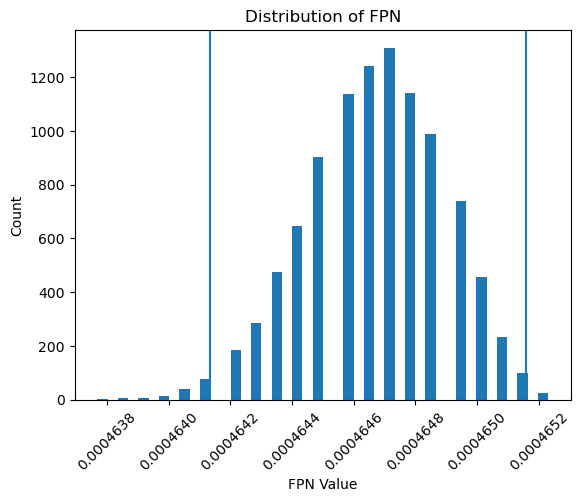

In [13]:
# ************************
# Examine FPN Distribution
# ************************

# create a histogram of FPN
plt.hist(fpn_img[:100, :100].flatten(), bins='auto') 
plt.xticks(rotation=45)
plt.xlabel('FPN Value')
plt.ylabel('Count')
plt.title('Distribution of FPN')
plt.axvline(np.percentile(fpn_img, 99)) # display verticle 99th percentile line
plt.axvline(np.percentile(fpn_img, 1))
plt.show()

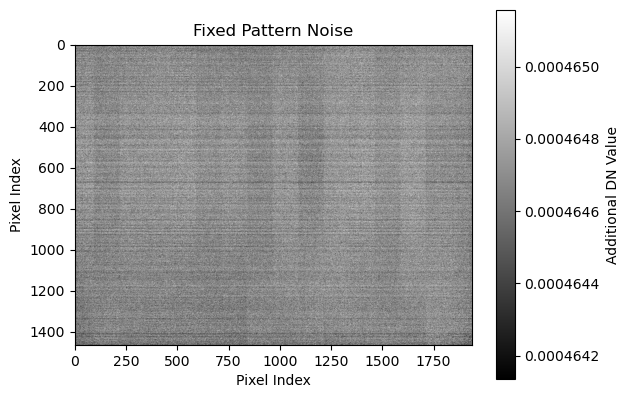

In [27]:
# ***************
# Displaying FPN
# ***************

'''
In the line below, vmax and vmin are being used to determine the range of values that will appear
between white and black. 

If this does not automatically yield a good result, try modifying the percentile values. Should this not help, 
try hand-picking values toward the lower and upper end of the distribution displayed in the FPN Histogram. 
Input these numerical values as such: vmax = 0.0004638. Vary values until a pattern appears. 
'''

plt.imshow(fpn_img, vmax = np.percentile(fpn_img, 99), vmin= np.percentile(fpn_img, 1), cmap='gray')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
cb = plt.colorbar()
cb.set_label("Additional DN Value")
plt.title('Fixed Pattern Noise')
plt.show()

In [17]:
# ***************
# Calculate PRNU
# ***************

# input folder paths here
light_path = r"FILE PATH HERE"
dark_path = r"FILE PATH HERE"

mean_light = get_mean_img(light_path, 'light_stacked')
mean_dark = get_mean_img(dark_path, 'dark_stacked')

light_minus_dark = mean_light - mean_dark
prnu_img = (np.std(light_minus_dark)) / (light_minus_dark)

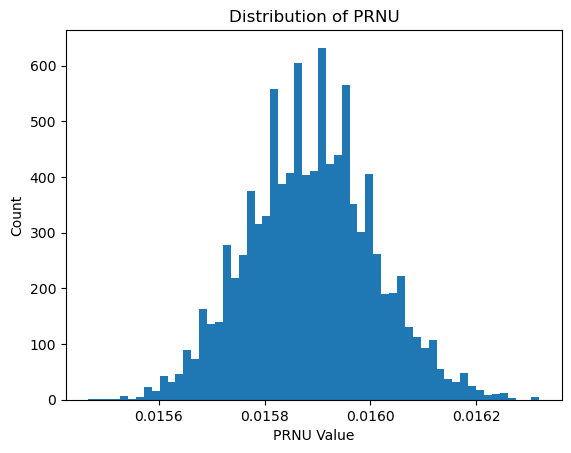

In [23]:
# *************************
# Examine PRNU Distribution
# *************************

# create a histogram of PRNU
plt.hist(prnu_img[:100, :100].flatten(), bins='auto') 
plt.xlabel('PRNU Value')
plt.ylabel('Count')
plt.title('Distribution of PRNU')
plt.show()

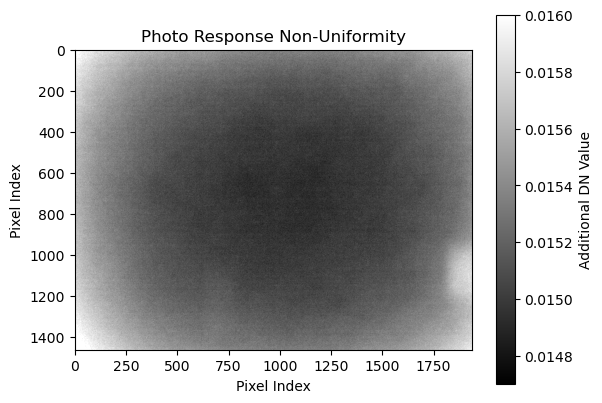

In [25]:
# ****************
# Displaying PRNU
# ****************

'''
Similar to the "Displaying FPN" section, vmax and vmin are determining what values of 
PRNU appear between white and black when displayed. 

The percentile approach used for FPN can be used here. However, I experienced
some struggles obtaining good results. Instead, I would recommend hand-selecting 
values near the upper and lower end of the distribution for vmax and vmin, respectively. 
'''

plt.imshow(prnu_img, vmax=0.016, vmin=0.0147, cmap='gray')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
cb = plt.colorbar()
cb.set_label('Additional DN Value')
plt.title('Photo Response Non-Uniformity')
plt.show()